## Code

### Libs

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

from matplotlib.colors import ListedColormap

### Kernels

In [ ]:
def linear(a, b):
    return np.dot(a, b)

In [ ]:
def sigmoid(a, b, gamma=1, k0=0):
    return np.tanh(gamma * np.dot(a, b) + k0)

In [ ]:
def gaussian(a, b, gamma=0.5):
    return np.exp(-gamma * np.power(np.linalg.norm(a - b), 2))

In [ ]:
def poly(a, b, gamma=1, k0=1, degree=3):
    return np.power(gamma * np.dot(a, b) + k0, degree)

In [ ]:
def build_kernel_function(name, gamma=1, k0=1, degree=3):
    if name == 'linear':
        return lambda a, b: linear(a, b)
    elif name == 'sigmoid':
        return lambda a, b: sigmoid(a, b, gamma, k0)
    elif name == 'gaussian':
        return lambda a, b: gaussian(a, b, gamma)
    elif name == 'poly':
        return lambda a, b: poly(a, b, gamma, k0, degree)

### Algo

In [ ]:
X = y = m = n = kernel = C = k = alphas = b = w = errors = tol = y2 = a2 = X2 = e2 = None

eps = 1e-3
MAX_ITER = 3000

In [ ]:
def kernel_matrix(kernel_func, A, B):
    n, *_ = A.shape
    m, *_ = B.shape
    f = lambda i, j: kernel_func(A[i], B[j])
    return np.fromfunction(np.vectorize(f), (n, m), dtype=int)

In [ ]:
def setVals(_X, _y, kernel_func, c, _tol=0.001):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol
    X = _X
    y = _y
    m, n = np.shape(X)
    kernel = kernel_func
    C = c
    k = kernel_matrix(kernel, X, X)
    alphas = np.zeros(m)
    b = 0
    w = np.zeros(n)
    errors = np.zeros(m)
    tol = _tol

In [ ]:
def predict(x):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol
    res = int(np.sign(np.sum([alphas[j] * y[j] * kernel(X[j], x) for j in range(m)]) - b))
    return res if res != 0 else 1

In [ ]:
def output(i):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol
    return sum([alphas[j] * y[j] * k[j][i] for j in range(m)]) - b

In [ ]:
def take_step(i1, i2):
    if i1 == i2:
        return False

    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2
    a1 = alphas[i1]
    y1 = y[i1]
    X1 = X[i1]
    e1 = get_error(i1)

    s = y1 * y2

    if y1 != y2:
        L = max(0, a2 - a1)
        H = min(C, C + a2 - a1)
    else:
        L = max(0, a2 + a1 - C)
        H = min(C, a2 + a1)

    if L == H:
        return False

    k11 = k[i1][i1]
    k12 = k[i1][i2]
    k22 = k[i2][i2]

    eta = k11 + k22 - 2 * k12

    if eta > 0:
        a2_new = a2 + y2 * (e1 - e2) / eta

        if a2_new < L:
            a2_new = L
        elif a2_new > H:
            a2_new = H
    else:
        f1 = y1 * (e1 + b) - a1 * k11 - s * a2 * k12
        f2 = y2 * (e2 + b) - s * a1 * k12 - a2 * k22
        L1 = a2 + s * (a2 - L)
        H1 = a1 + s * (a2 - H)
        Lobj = L1 * f1 + L * f2 + 0.5 * (L1 ** 2) * k11 + 0.5 * (L ** 2) * k22 + s * L * L1 * k12
        Hobj = H1 * f1 + H * f2 + 0.5 * (H1 ** 2) * k11 + 0.5 * (H ** 2) * k22 + s * H * H1 * k12

        if Lobj < Hobj - eps:
            a2_new = L
        elif Lobj > Hobj + eps:
            a2_new = H
        else:
            a2_new = a2

    if abs(a2_new - a2) < eps * (a2_new + a2 + eps):
        return False

    a1_new = a1 + s * (a2 - a2_new)

    new_b = compute_b(e1, a1, a1_new, a2_new, k11, k12, k22, y1)

    delta_b = new_b - b

    b = new_b

    delta1 = y1 * (a1_new - a1)
    delta2 = y2 * (a2_new - a2)

    for i in range(m):
        if 0 < alphas[i] < C:
            errors[i] += delta1 * k[i1][i] + delta2 * k[i2][i] - delta_b

    errors[i1] = 0
    errors[i2] = 0

    alphas[i1] = a1_new
    alphas[i2] = a2_new

    return True

In [ ]:
def compute_b(e1, a1, a1_new, a2_new, k11, k12, k22, y1):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2

    b1 = e1 + y1 * (a1_new - a1) * k11 + y2 * (a2_new - a2) * k12 + b
    b2 = e2 + y1 * (a1_new - a1) * k12 + y2 * (a2_new - a2) * k22 + b

    if (0 < a1_new) and (C > a1_new):
        new_b = b1
    elif (0 < a2_new) and (C > a2_new):
        new_b = b2
    else:
        new_b = (b1 + b2) / 2
    return new_b

In [ ]:
def get_error(i1):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol
    if 0 < alphas[i1] < C:
        return errors[i1]
    else:
        return output(i1) - y[i1]

In [ ]:
def second_heuristic(non_bound_indices):
    i1 = -1
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol
    if len(non_bound_indices) > 1:
        max = 0

        for j in non_bound_indices:
            e1 = errors[j] - y[j]
            step = abs(e1 - e2)
            if step > max:
                max = step
                i1 = j
    return i1

In [ ]:
def examine_example(i2):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2
    y2 = y[i2]
    a2 = alphas[i2]
    X2 = X[i2]
    e2 = get_error(i2)

    r2 = e2 * y2

    if not ((r2 < -tol and a2 < C) or (r2 > tol and a2 > 0)):
        return 0

    non_bound_idx = list(get_non_bound_indices())
    i1 = second_heuristic(non_bound_idx)

    if i1 >= 0 and take_step(i1, i2):
        return 1

    rand_i = random.randrange(m)
    all_indices = list(range(m))
    for i1 in all_indices[rand_i:] + all_indices[:rand_i]:
        if take_step(i1, i2):
            return 1

    return 0

In [ ]:
def error(i2):
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2
    return output(i2) - y2

In [ ]:
def get_non_bound_indices():
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2
    return np.where(np.logical_and(alphas > 0, alphas < C))[0]

In [ ]:
def first_heuristic():
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2
    num_changed = 0
    non_bound_idx = get_non_bound_indices()
    for i in non_bound_idx:
        num_changed += examine_example(i)
    return num_changed

In [ ]:
def execute():
    global X, y, m, n, kernel, C, k, alphas, b, w, errors, tol, y2, a2, X2, e2
    num_changed = 0
    examine_all = True
    iter = 0
    while iter < MAX_ITER and (num_changed > 0 or examine_all):
        iter += 1
        num_changed = 0

        if examine_all:
            for i in range(m):
                num_changed += examine_example(i)
            else:
                num_changed += first_heuristic()

            if examine_all:
                examine_all = False
            elif num_changed == 0:
                examine_all = True

### Execute preps

In [ ]:
C_vals = [0.01, 0.1, 1, 10, 50]

linear_params = np.array([{'name': 'linear', 'C': C} for C in C_vals])
sigmoid_params = np.array([{'name': 'sigmoid', 'gamma': gamma, 'k0': k0, 'C': C}
                           for gamma in [0.5, 0.75, 1.0]
                           for k0 in [0.0, 0.5, 1.0]
                           for C in C_vals])
gaussian_params = np.array([{'name': 'gaussian', 'gamma': gamma, 'C': C}
                            for gamma in [0.1, 0.3, 0.5]
                            for C in C_vals])
poly_params = np.array([{'name': 'poly', 'gamma': gamma, 'k0': k0, 'C': C, 'degree': degree}
                        for gamma in [0.01, 0.5, 1.0]
                        for k0 in [0, 0.5, 1]
                        for degree in [3, 4, 5]
                        for C in C_vals])
all_params = [linear_params, sigmoid_params, gaussian_params, poly_params]

In [ ]:
def build(params, X, y):
    name = params['name']
    C = params['C']
    gamma = params.get('gamma', None)
    k0 = params.get('k0', None)
    degree = params.get('degree', None)
    kernel_func = build_kernel_function(name, gamma, k0, degree)
    setVals(X, y, kernel_func, C)
    execute()

In [ ]:
def eval_score(params, X, y):
    kf = KFold(n_splits=5)
    f_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        build(params, X_train, y_train)
        y_pred = np.apply_along_axis(lambda x: predict(x), 1, X_test)
        f_scores.append(f1_score(y_test, y_pred))
    return np.average(np.array(f_scores))

In [ ]:
def find_best_params(X, y):
    res = []
    for k_p in all_params:
        scores = []
        for p in k_p:
            print(p)
            score = eval_score(p, X, y)
            print(score)
            scores.append(score)
        res.append(k_p[np.argmax(np.array(scores))])
        res[-1]['score'] = max(scores)

    return res

In [ ]:
def draw(name, p, X, y, step):
    stepx = step
    stepy = step
    x_min, y_min = np.amin(X, 0)
    x_max, y_max = np.amax(X, 0)
    x_min -= stepx
    x_max += stepx
    y_min -= stepy
    y_max += stepy
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stepx),
                         np.arange(y_min, y_max, stepy))

    mesh_dots = np.c_[xx.ravel(), yy.ravel()]
    zz = np.apply_along_axis(lambda t: predict(t), 1, mesh_dots)
    zz = np.array(zz).reshape(xx.shape)

    plt.figure(figsize=(10, 10))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    x0, y0 = X[y == -1].T
    x1, y1 = X[y == 1].T

    plt.pcolormesh(xx, yy, zz, cmap=ListedColormap(['#AFA', '#FAA']))
    plt.scatter(x0, y0, color='green', s=100)
    plt.scatter(x1, y1, color='red', s=100)

    sup_ind = get_non_bound_indices()
    X_sup = X[sup_ind]
    x_sup, y_sup = X_sup.T

    plt.scatter(x_sup, y_sup, color='white', marker='x', s=60)
    plt.show()

In [ ]:
def process(name):
    df = pd.read_csv(name + '.csv')
    X = df.values[:, :-1]
    y = df.values[:, -1]
    y = np.vectorize(lambda y_i: 1 if y_i == 'P' else -1)(y)
    indices = np.arange(y.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    params = find_best_params(X, y)
    for p in params:
        print(name + ' dataset, ' + p['name'] + ' kernel:')
        print(p)
        build(p, X, y)
        draw(name, p, X, y, 0.05)

## Results

### Chips

{'name': 'linear', 'C': 0.01}
0.27292277614858257
{'name': 'linear', 'C': 0.1}
0.0
{'name': 'linear', 'C': 1}
0.14767025089605731
{'name': 'linear', 'C': 10}
0.23342188488298543
{'name': 'linear', 'C': 50}
0.6741519161841742
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 0.01}
0.1032258064516129
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 0.1}
0.11666666666666667
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 1}
0.14736842105263157
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 10}
0.47804177481151894
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 50}
0.3036484593837535
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 0.01}
0.0
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 0.1}
0.1032258064516129
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 1}
0.044444444444444446
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 10}
0.2495384615384615
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 50}
0.3063906269169427
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 1.0, 'C': 0

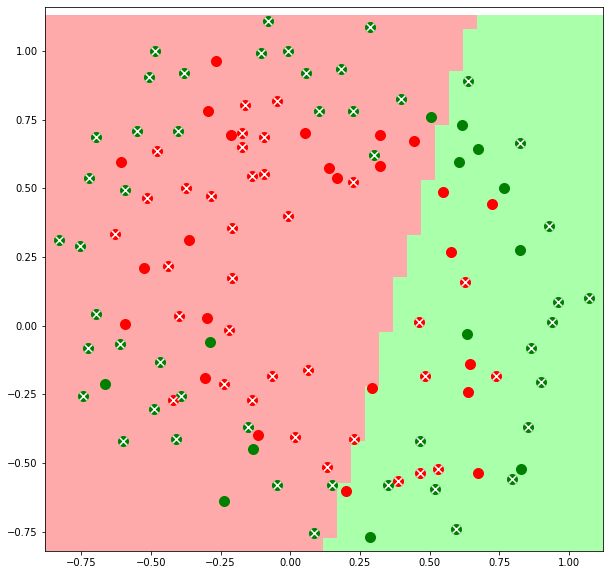

chips dataset, sigmoid kernel:
{'name': 'sigmoid', 'gamma': 1.0, 'k0': 0.0, 'C': 50, 'score': 0.48783766233766246}


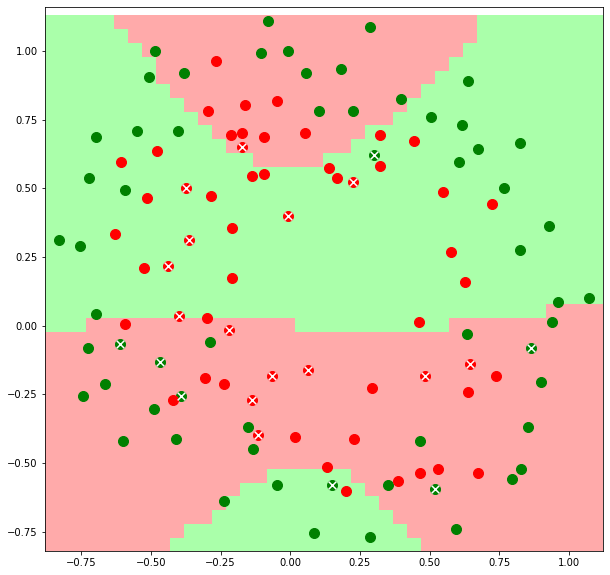

chips dataset, gaussian kernel:
{'name': 'gaussian', 'gamma': 0.5, 'C': 10, 'score': 0.7892856323816076}


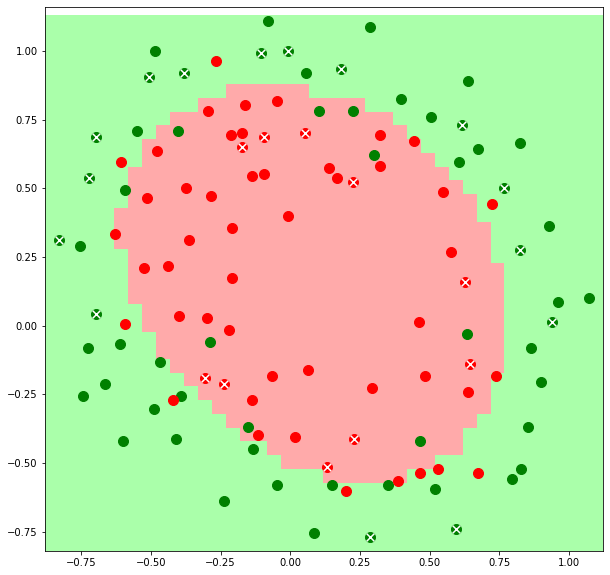

chips dataset, poly kernel:
{'name': 'poly', 'gamma': 1.0, 'k0': 1, 'C': 1, 'degree': 3, 'score': 0.7946788079780408}


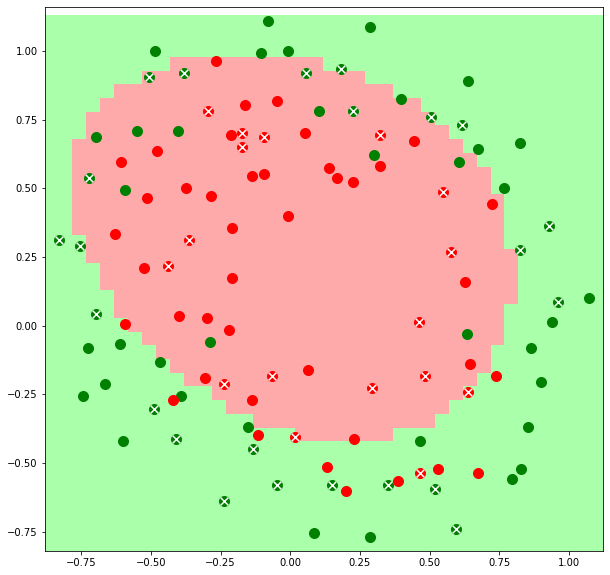

In [ ]:
process('chips')

### Geyser

{'name': 'linear', 'C': 0.01}
0.8487239117471675
{'name': 'linear', 'C': 0.1}
0.8568863049095607
{'name': 'linear', 'C': 1}
0.6912729442654255
{'name': 'linear', 'C': 10}
0.5132875264270613
{'name': 'linear', 'C': 50, 'score': 0.6741519161841742}
0.3674044795783926
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 0.01}
0.09824561403508772
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 0.1}
0.10491803278688525
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 1}
0.058333333333333334
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 10}
0.0
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.0, 'C': 50}
0.014814814814814814
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 0.01}
0.025806451612903226
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 0.1}
0.18226600985221672
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 1}
0.19836990595611287
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 10}
0.0
{'name': 'sigmoid', 'gamma': 0.5, 'k0': 0.5, 'C': 50}
0.28408419167039856
{'name': 'sigmoid',

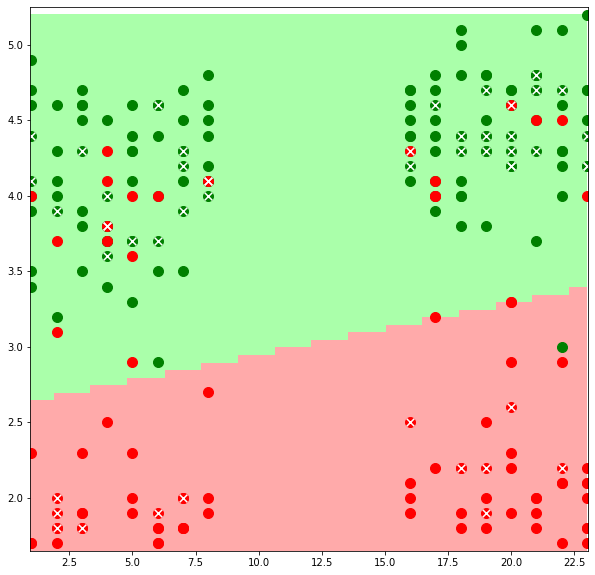

geyser dataset, sigmoid kernel:
{'name': 'sigmoid', 'gamma': 0.75, 'k0': 0.5, 'C': 0.01, 'score': 0.34639729315670037}


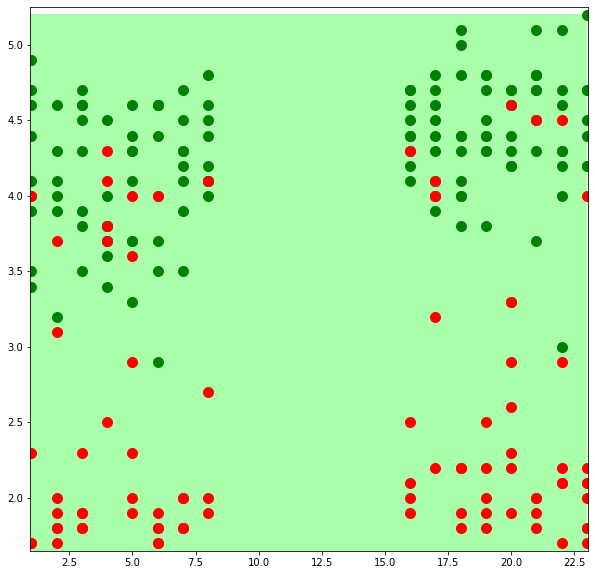

geyser dataset, gaussian kernel:
{'name': 'gaussian', 'gamma': 0.3, 'C': 1, 'score': 0.8529656007075361}


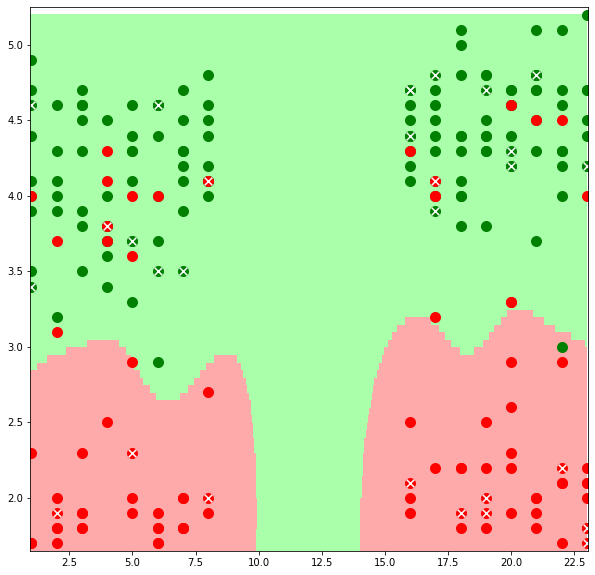

geyser dataset, poly kernel:
{'name': 'poly', 'gamma': 0.01, 'k0': 0.5, 'C': 10, 'degree': 3, 'score': 0.7101468710089401}


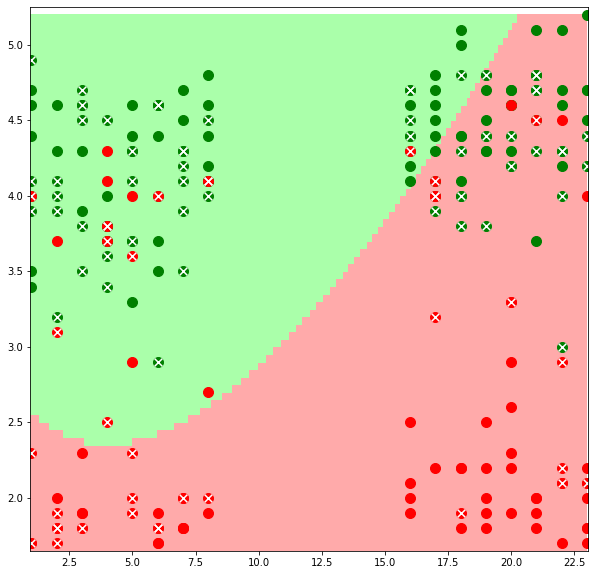

In [ ]:
process('geyser')